## Imports

In [2]:
#Versión para tweepy V2
from datetime import date, datetime, timedelta
import datetime
import requests
import json
import time
from pathlib import Path
import math
import pymongo
from bson import ObjectId
import numpy as np
from datetime import date
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import geometry, ops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import figure
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Dictionaries

In [3]:
user_dictionary = {
    "_id"               : None,
    "description"       : '',
    "created_at"        : '',
    "verified"          : '',
    "followers_count"   : 0,
    "following_count"   : 0
}


tweet_dictionary = {
    "_id"               : None,
    "author_id"         : '',
    "created_at"        : '',
    "text"              : '',
    "hashtag"           : [],
    "referenced_tweets" : [],
    "retweet_count"     : 0,
    "reply_count"       : 0,
    "reply_count"       : 0,
    "like_count"        : 0
}


node = {
    "hashtag"           : '',
    "current_date"        : '',
    "next_date"        : '',
    "next_token"        : '-1'
}

## Support functions

In [24]:

def GetHashtagList():
    hashtags_list = []
    hashtag = ''
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())

    f.close()
    return hashtags_list

def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')
        
    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def PetitionToDayMonthYear(petition):
    """
    """
    splited = ''
    time = ''
    splited = petition.split('T')
    time = splited[1]
    splited = splited[0].split('-')
    return (splited[2] + '-' + splited[1] + '-' + splited[0] + 'T' + time)

def IsUnknown(user_id, user_list):
    for user in user_list:
        if (str(user['_id']) == str(user_id)):
            return False
    return True

def NextDate(current_date):
    '''
        current_date: D'ia de entrada
        return: Devuelve el d'ia siguiente al d'ia actual
    '''
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days=1)
    return dat.strftime("%d/%m/%Y").split(' ')[0]

def NextDatePetition(current_date):
    '''
        current_date: D'ia de entrada
        return: Devuelve el d'ia siguiente al d'ia actual
    '''
    dat = datetime.datetime.strptime(current_date, "%Y-%m-%d")
    dat += datetime.timedelta(days=1)
    return dat.strftime("%Y-%m-%d").split(' ')[0]

def truncate(n):
    s = str(float(n)).split('.')
    return int(s[0])


## Experimentation

### Daily numbers of tweets and retweets with annotation of important external events.

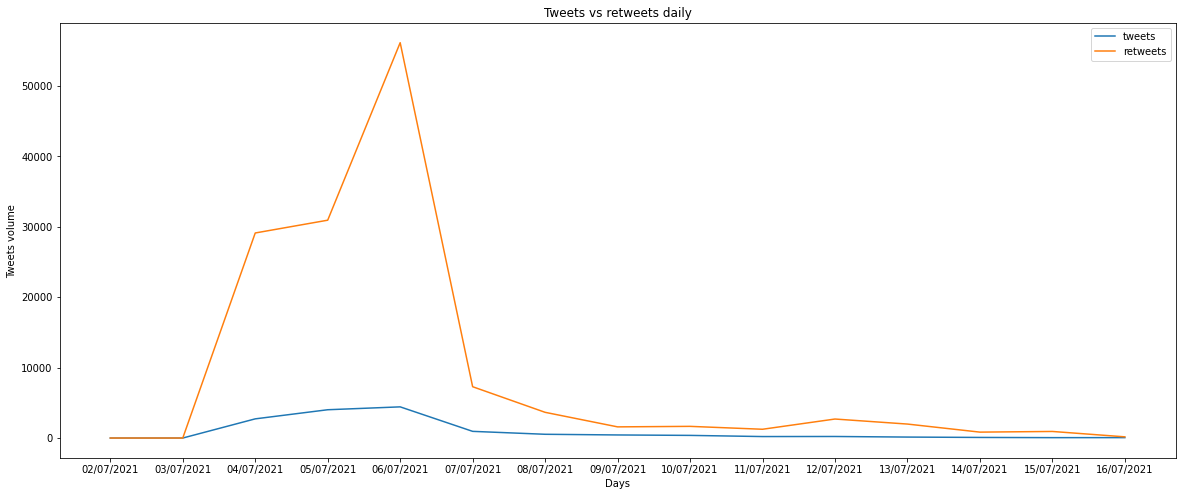

[0, 0, 2723, 4018, 4427, 948, 533, 437, 375, 210, 220, 136, 85, 55, 58]
[0, 0, 29122, 30938, 56148, 7288, 3652, 1585, 1658, 1246, 2699, 1984, 839, 934, 170]


In [5]:
# primera noticia que veo es el lunes, 5 de julio del 2021
def DailyTweetsAndRetweets(start, end, database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]
    current_date = start
    today = ''
    list_days = []
    list_day_tweet_count = []
    list_day_retweet_count = []
    while current_date != end:
        day = DayMonthYearToPetition(current_date) + 'T00:00:0.000Z'
        gte = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')

        day = DayMonthYearToPetition(current_date) + 'T11:59:59.000Z'
        lt = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        tweets_not_retweets = len(list(mytweets.find( {"$and": [ { "referenced_tweets.type" : {"$ne": "retweeted"} }, { "created_at" : { '$gte' : gte , '$lt' : lt }} ] } )))
        tweets_retweets = len(list(mytweets.find( {"$and": [ {"referenced_tweets.type" : "retweeted"}, {"created_at" : { '$gte' : gte , '$lt' : lt }} ] } )))
        
        list_days.append(current_date)
        list_day_tweet_count.append(tweets_not_retweets)
        list_day_retweet_count.append(tweets_retweets)
        current_date = NextDate(current_date)

    #print plot here
    plt.figure(figsize=(20,8))
    plt.plot(list_days, list_day_tweet_count, label = "tweets")
    # plotting the line 2 points 
    plt.plot(list_days, list_day_retweet_count, label = "retweets")
    
    # naming the x axis
    plt.xlabel('Days')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title('Tweets vs retweets daily')
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()
    print(list_day_tweet_count)
    print(list_day_retweet_count)
    
DailyTweetsAndRetweets("02/07/2021", "17/07/2021", "mydatabase_clone", "tweets_clone", "users_clone")

### Top-10 most tweeted and retweeted keywords.

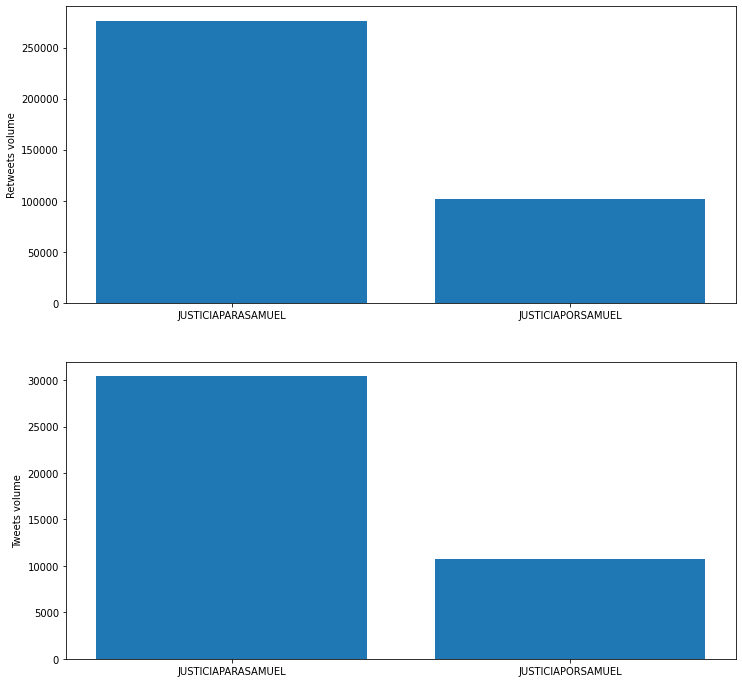

Tweet list: [30394, 10750]
Retweet list: [276445, 101311]


In [8]:
def Top10MostTweetsAndRetweets(database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]
    
    hashtag_retweet = {}
    hashtag_tweet = {}

    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    hashtags_list = GetHashtagList()
    hashtag = ''
    
    
    for h in hashtags_list:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "hashtag": h } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"hashtag" : h  } ] } )))
        
        hashtag_retweet[h] = tweets_retweets
        hashtag_tweet[h] = tweets_not_retweets
          
            
    sort_hashtag_retweet = sorted(hashtag_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_hashtag_tweet = sorted(hashtag_tweet.items(), key=lambda x: x[1], reverse=True)
    
    for node in sort_hashtag_retweet[0:10]:
        list_hashtag_retweet.append(node[1])
        list_hashtags.append(node[0])
    #print plot here
    
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    plt.subplot(2,1,1)
    #This will create the bar graph for poulation
    pop = plt.bar(list_hashtags, list_hashtag_retweet)
    plt.ylabel('Retweets volume')
    
    list_hashtags = []
    list_hashtag_tweet = []
    if len(sort_hashtag_tweet) > 10:
        for node in sort_hashtag_tweet[0:10]:
            list_hashtag_tweet.append(node[1])
            list_hashtags.append(node[0])
        plt.xticks(range(10), list_hashtags, rotation='horizontal')
    else:
        for node in sort_hashtag_tweet:
            list_hashtag_tweet.append(node[1])
            list_hashtags.append(node[0])
        plt.xticks(range(len(list_hashtags)), list_hashtags, rotation='horizontal')
        
    plt.subplot(2,1,2)
    #This will create the bar graph for gdp i.e gdppercapita divided by population.
    gdp =plt.bar(list_hashtags, list_hashtag_tweet)
    plt.ylabel('Tweets volume')
    #plt.xlabel('Hashtags')
    if len(sort_hashtag_tweet) > 10:
        plt.xticks(range(10), list_hashtags, rotation='horizontal')
    else:
        plt.xticks(range(len(list_hashtags)), list_hashtags, rotation='horizontal')
        
    plt.show()
    
    print('Tweet list:', list_hashtag_tweet)
    print('Retweet list:',list_hashtag_retweet)
    
Top10MostTweetsAndRetweets("mydatabase_clone", "tweets_clone", "users_clone")

### Word clouds with the top-100 most popular words in numbers of tweets and retweets.

There are 68918952 words in the combination of all tweets.


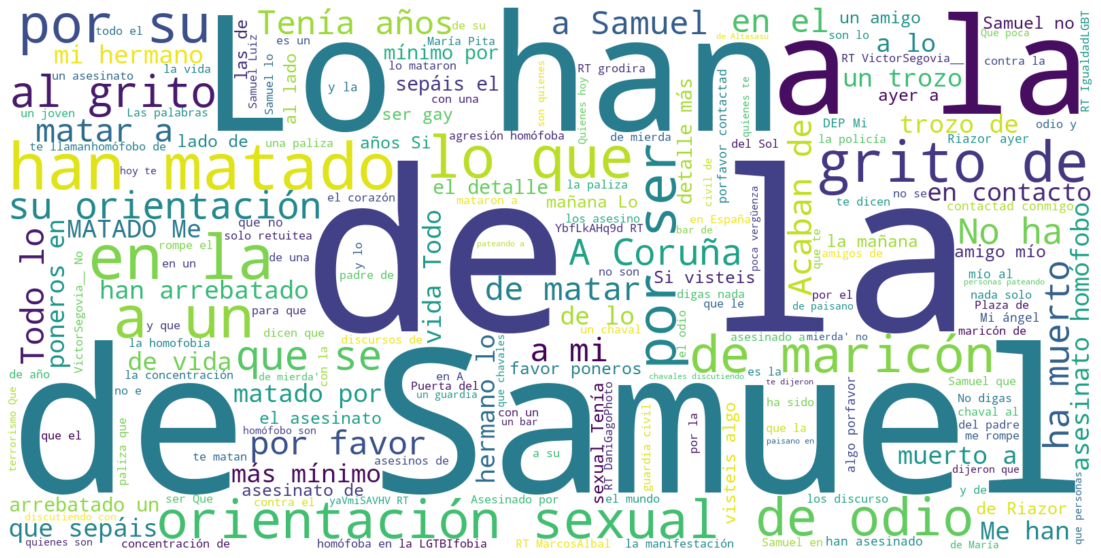

In [10]:
def ExperimentsWordCloud(database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]
    
    hashtags_list = GetHashtagList()
    
    stopwords = set(hashtags_list)
    stopwords.update(['https', 'co', 't'])
    
    
    tweet_list  = mytweets.find()
    df = pd.DataFrame.from_dict(tweet_list)
    text = " ".join(review for review in df.text)
    print ("There are {} words in the combination of all tweets.".format(len(text)))
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1600, height=800, stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
ExperimentsWordCloud("mydatabase_clone", "tweets_clone", "users_clone")

### Hashtags popularity over the weeks.

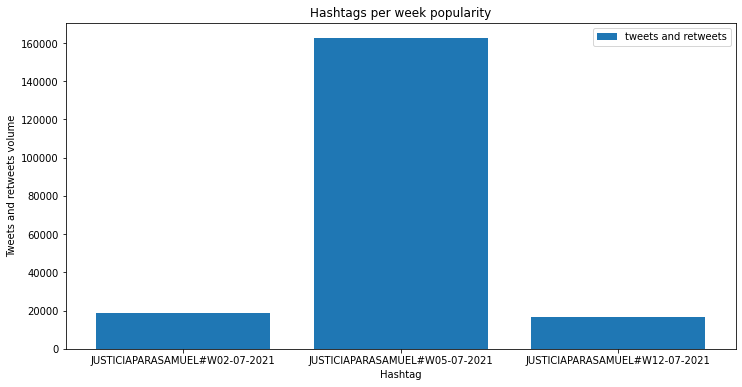

['JUSTICIAPARASAMUEL#W02-07-2021', 'JUSTICIAPARASAMUEL#W05-07-2021', 'JUSTICIAPARASAMUEL#W12-07-2021']
[18664, 162497, 16657]


In [29]:
def datespan(startDate, endDate):
    current_date = startDate
    dat = datetime.datetime.strptime(current_date, "%Y-%m-%d")
    if (dat.weekday()//6 == 0):
        dat += datetime.timedelta(days= (6 - dat.weekday()))
    else:
        dat += datetime.timedelta(days= 6)
                                  
    next_date = dat.strftime("%Y-%m-%d").split(' ')[0]
    if current_date > endDate:
        return endDate
    else: 
        return next_date

def HashtagsPerWeekPopularity(startDate, endDate, database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]
    
    hashtags_list = GetHashtagList()
    hashtags_plt = []
    count_plt = []
    
    hashtag_count = {}
    
    current_date = DayMonthYearToPetition(startDate)
    endDate = DayMonthYearToPetition(endDate)
    
    
    next_date = ''
    gte = ''
    lt = ''
    week_count = 1
    while current_date < endDate:
        next_date = datespan(current_date, endDate)
        for h in hashtags_list:
            day = current_date + 'T00:00:0.000Z'
            gte = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
            day = next_date + 'T00:00:0.000Z'
            lt = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
            hashtag_count[h] = len(list(mytweets.find( { "$and": [ { 'hashtag' : h }, { 'created_at' : { '$gte' : gte , '$lt' : lt } } ] } )))
        #aqui obtenemos el hashtag con mayor cantida de tweets y retweets y lo insertamos en la lista final
        sort_hashtag_count = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
        hashtags_plt.append(sort_hashtag_count[0][0] + '#W' + str(DayMonthYearToPetition(current_date)))
        count_plt.append(sort_hashtag_count[0][1])
        #cambio a la siguiente semana
        current_date = NextDatePetition(next_date)
        hashtag_count = {}
        week_count += 1 
        gte = ''
        lt = ''
        
    plt.figure(figsize=(12,6))
    plt.bar(hashtags_plt, count_plt, label = "tweets and retweets")
    # naming the x axis
    plt.xlabel('Hashtag')
    # naming the y axis
    plt.ylabel('Tweets and retweets volume')
    # giving a title to my graph
    plt.title("Hashtags per week popularity")
    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()
    
   
    print(hashtags_plt)
    print(count_plt)
            

HashtagsPerWeekPopularity("02/07/2021", "17/07/2021", "mydatabase_clone", "tweets_clone", "users_clone")

### Top-5 most active verified user accounts.

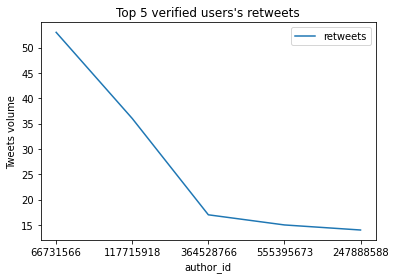

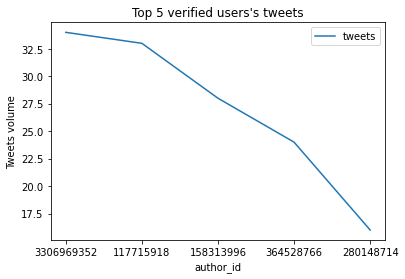

In [30]:
def Top5VerifiedUserTweets(database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]
    
    users = []
    user_retweet = {}
    user_tweet = {}
    
    try:
        users = list(myusers.find( { "verified" : True } ))
    except Exception as e:        
        pass

    list_user = []
    list_user_retweet = []
    list_user_tweet = []
    
    for u in users:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "author_id": u['_id'] } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"author_id": u['_id'] } ] } )))
        user_retweet[u['_id']] = tweets_retweets
        user_tweet[u['_id']] = tweets_not_retweets
                        
    sort_user_retweet = sorted(user_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_user_tweet = sorted(user_tweet.items(), key=lambda x: x[1], reverse=True)
    
    
    for node in sort_user_retweet[0:5]:
        list_user_retweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    # plotting the line 2 points 
    plt.figure(1)
    plt.plot(list_user, list_user_retweet, label = "retweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's retweets")
    # show a legend on the plot
    plt.legend()
    
    list_user = []
    for node in sort_user_tweet[0:5]:
        list_user_tweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    #print plot here
    plt.figure(0)
    plt.plot(list_user, list_user_tweet, label = "tweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's tweets")
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()
    
Top5VerifiedUserTweets("mydatabase_clone", "tweets_clone", "users_clone")

### Heat map

1820
[2, 16, 0, 0, 47, 36, 14, 126, 568, 153, 121, 111, 221, 25, 45, 0, 38, 0, 1, 200]


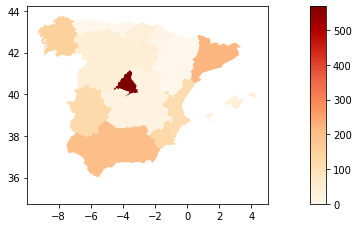

In [31]:
def HeatMap(database, tweets_collection, users_collection):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient[database]
    mytweets = mydb[tweets_collection]
    myusers = mydb[users_collection]

    tweet_list = list(mytweets.find( {'$and': [{ "place" : {"$ne": ""}}, {'geo.country': 'España'}] }))
    print(str(len(tweet_list)))


    # set the filepath and load
    fp = 'recintos_autonomicas_inspire_peninbal_etrs89.shp'
    #reading the file stored in variable fp
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe

    list_comunidades_count = [0 for i in range(len(map_df.NAMEUNIT))]



    for tweet in tweet_list:
        index = 0
        while index < len(map_df.NAMEUNIT):
            line = LineString([(tweet['geo']['geo']['bbox'][0], tweet['geo']['geo']['bbox'][1]), (tweet['geo']['geo']['bbox'][2], tweet['geo']['geo']['bbox'][3])])
            if line.distance(map_df.geometry[index]) < 0.6:
                list_comunidades_count[index] = list_comunidades_count[index] + 1
                break
            index += 1

    print(list_comunidades_count)
    map_df['count_tweets'] = list_comunidades_count
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    map_df.plot(column='count_tweets', ax=ax, legend=True, cax=cax, cmap='OrRd')

HeatMap("mydatabase_clone", "tweets_clone", "users_clone")